<h1> 🥊 📊 UFC Data Analysis

Goal of analysis: Which fights stats of a fighter are correlated with wins? <br>
Physical stats considered: Knockdowns, takedowns landed, significant strikes, submission attempts. <br>
Got data from 2020 onwards because I am more familiar with the modern trends of the sport (Data ends at 30 AUG). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


sns.set_theme(style="whitegrid", palette="pastel")

In [2]:
event_df = pd.read_csv("ufc_data/ufc_event_data.csv")
fighter_df = pd.read_csv("ufc_data/ufc_fighters.csv")

<h3> Cleaning the Data


In [3]:
fighter_df = fighter_df.drop(["Nickname"], axis=1) 

fighter_df["Fighter Name"] = fighter_df["First Name"] + " " + fighter_df["Last Name"]
fighter_df = fighter_df.drop(["First Name", "Last Name"], axis=1)

fighter_df.head(5)

,Height,Weight,Reach,Stance,Wins,Losses,Draws,Fighter Name
0,--,155 lbs.,--,NaN,5,3,0,Tom Aaron
1,"5' 11""",155 lbs.,--,Orthodox,4,6,0,Danny Abbadi
2,"5' 8""",155 lbs.,"66.0""",Orthodox,28,4,0,Nariman Abbasov
3,"6' 2""",265 lbs.,"80.0""",Orthodox,9,5,0,Darion Abbey
4,"6' 0""",265 lbs.,--,Switch,10,15,0,David Abbott


In [4]:
event_df["Event Date"] = pd.to_datetime(event_df["Event Date"])

event_df = event_df.rename(columns={
  "Event Name": "Name",
  "KD": "Knockdowns",
  "TD": "Takedowns Landed", # Not attempted takedowns
  "Sub": "Submission Attempts",
  "Strikes": "Sig Strikes" # Not total strikes
})

# separate the fighter1 and fighter2 stuff from the dash. E.g. Fighter1_TD, Fighter2_KD, etc...
def separate_endash(string: str):
  parts = re.split(r"-", string, maxsplit=1)
  fighter1_stats = int(parts[0])
  fighter2_stats = int(parts[1])
  
  return fighter1_stats, fighter2_stats

for col in ("Sig Strikes", "Takedowns Landed", "Submission Attempts", "Knockdowns"):
  event_df[f"Fighter1 {col}"] = event_df[col].apply(lambda x: separate_endash(x)[0])
  event_df[f"Fighter2 {col}"] = event_df[col].apply(lambda x: separate_endash(x)[1])

event_df = event_df.drop(columns=["Sig Strikes", "Takedowns Landed", "Submission Attempts", "Knockdowns", "Weight Class", "Round", "Time", "Name", "Event Date"])

event_df.dtypes

Result                          object
Fighter1                        object
Fighter2                        object
Method                          object
Fighter1 Sig Strikes             int64
Fighter2 Sig Strikes             int64
Fighter1 Takedowns Landed        int64
Fighter2 Takedowns Landed        int64
Fighter1 Submission Attempts     int64
Fighter2 Submission Attempts     int64
Fighter1 Knockdowns              int64
Fighter2 Knockdowns              int64
dtype: object

In [5]:
"""
Change "Fighter1" to "Winner" and "Fighter2" to "Loser" since i've sorted out the draws and NCs.
"""

event_df = event_df[~event_df["Result"].isin(["Draw", "NC"])]

base_dict = {
  "Fighter1": "Winner",
  "Fighter2": "Loser"
}

stats = ["", "Sig Strikes", "Takedowns Landed", "Submission Attempts", "Knockdowns"]

renaming = {}
for fighter, w_or_l in base_dict.items():
  for stat in stats:
    renaming[f"{fighter} {stat}"] = f"{w_or_l} {stat}"

event_df = event_df.rename(columns=renaming)

event_df

,Result,Fighter1,Fighter2,Method,Winner Sig Strikes,Loser Sig Strikes,Winner Takedowns Landed,Loser Takedowns Landed,Winner Submission Attempts,Loser Submission Attempts,Winner Knockdowns,Loser Knockdowns
0,Johnny Walker,Johnny Walker,Zhang Mingyang,KO/TKO-Punches,50,20,0,0,0,0,1,0
1,Aljamain Sterling,Aljamain Sterling,Brian Ortega,U-DEC,124,55,3,0,0,0,0,0
2,Sergei Pavlovich,Sergei Pavlovich,Waldo Cortes-Acosta,U-DEC,61,45,0,0,0,0,0,0
3,Sumudaerji,Sumudaerji,Kevin Borjas,U-DEC,73,16,0,0,0,0,0,0
4,Taiyilake Nueraji,Taiyilake Nueraji,Kiefer Crosbie,KO/TKO-Elbows,27,2,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2858,Sodiq Yusuff,Sodiq Yusuff,Andre Fili,U-DEC,73,49,0,3,1,0,0,0
2859,Askar Askarov,Askar Askarov,Tim Elliott,U-DEC,73,47,0,3,0,0,0,0
2860,Drew Dober,Drew Dober,Nasrat Haqparast,KO/TKO-Punch,13,7,0,0,0,0,1,0
2861,Aleksa Camur,Aleksa Camur,Justin Ledet,U-DEC,80,44,1,0,0,0,0,0


In [6]:
event_df.describe()

,Winner Sig Strikes,Loser Sig Strikes,Winner Takedowns Landed,Loser Takedowns Landed,Winner Submission Attempts,Loser Submission Attempts,Winner Knockdowns,Loser Knockdowns
count,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000
mean,53.515831,37.349698,1.423693,0.658129,0.429385,0.154038,0.367485,0.052295
std,39.676880,31.876883,2.024791,1.199119,0.816366,0.501351,0.608770,0.236608
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,31.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,76.000000,55.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,445.000000,271.000000,14.000000,9.000000,7.000000,5.000000,6.000000,2.000000


<h3> Analysing and Visualising

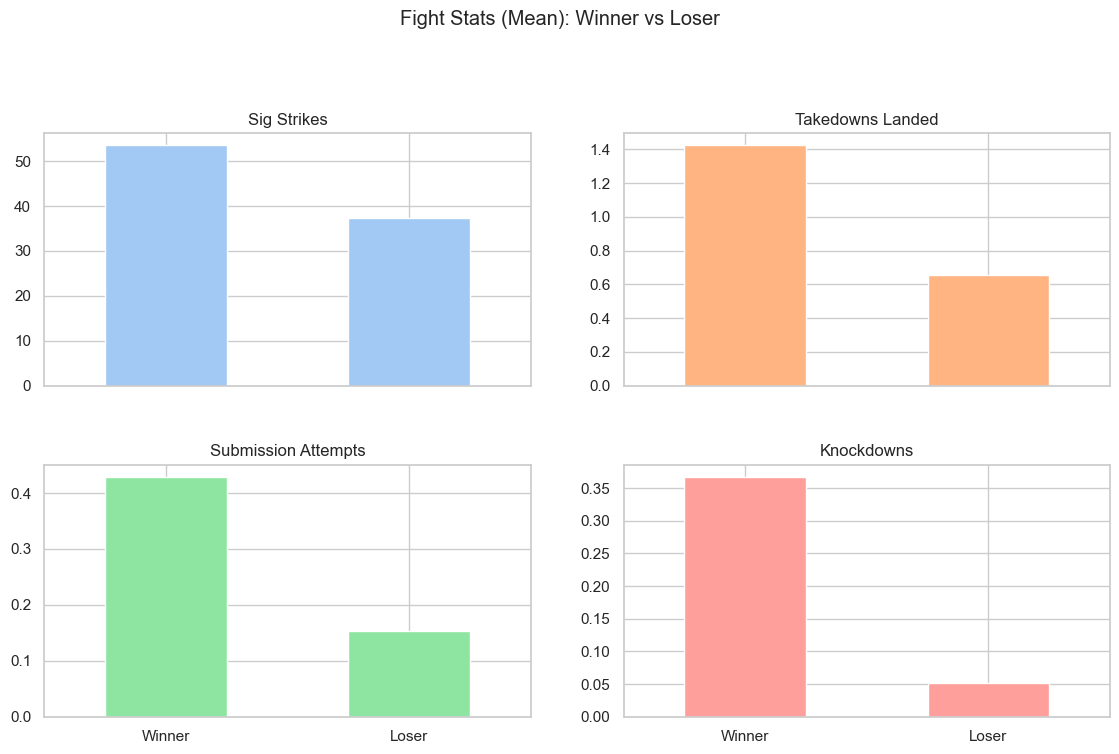

In [7]:
col_means = event_df.select_dtypes(include="number").mean()

stats = pd.DataFrame({
  "Sig Strikes": [col_means["Winner Sig Strikes"], col_means["Loser Sig Strikes"]],
  "Takedowns Landed": [col_means["Winner Takedowns Landed"], col_means["Loser Takedowns Landed"]],
  "Submission Attempts": [col_means["Winner Submission Attempts"], col_means["Loser Submission Attempts"]],
  "Knockdowns": [col_means["Winner Knockdowns"], col_means["Loser Knockdowns"]],
}, index=["Winner", "Loser"])

# Plot directly from pandas
stats.plot(kind="bar", subplots=True, layout=(2, 2), figsize=(12, 8), legend=False, rot=0)

plt.suptitle("Fight Stats (Mean): Winner vs Loser")
plt.tight_layout(pad=3)
plt.show()


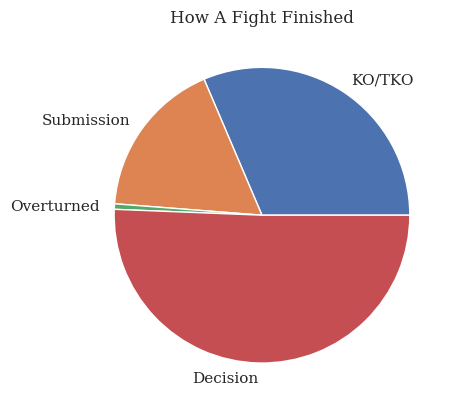

In [8]:
"""
How did the fights end?
"""

fight_ended_df = pd.read_csv("ufc_data/ufc_event_data.csv")["Method"]

replacement_map = {
  r".*KO/TKO.*": "KO/TKO",
  r".*SUB.*": "Submission",
  r".*Overturned.*": "Overturned",
  r".*DEC.*": "Decision"
}

fight_ended_df = fight_ended_df.replace(replacement_map, regex=True) # also ai generated

fight_ended_count = [(fight_ended_df == method).sum() for method in ("KO/TKO","Submission", "Overturned", "Decision")]
methods = [value for value in replacement_map.values()]

sns.set_theme(style="whitegrid", font="Serif")
colors = sns.color_palette('pastel')[0:len(fight_ended_count)]

plt.title("How A Fight Finished")
plt.pie(fight_ended_count, labels=methods)
plt.show()


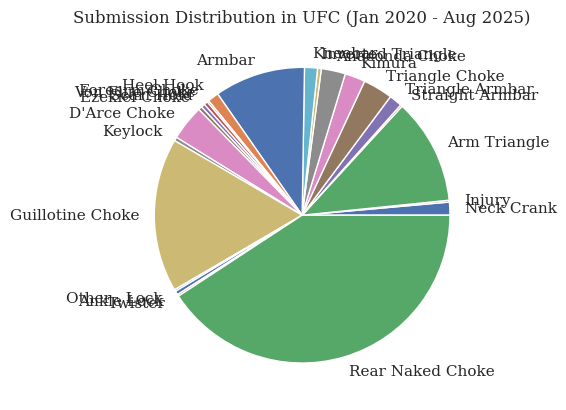

In [ ]:
"""
Looking at the Submission subset. 
"""

fight_ended_df = pd.read_csv("ufc_data/ufc_event_data.csv")["Method"] # this is as series not df, so syntax is slightly different

def is_submission(series):
  subs_list = []
  for term in series:
    if "SUB" in term:
      subs_list.append(term)
    else: 
      continue
  return subs_list

subs = pd.Series(is_submission(fight_ended_df))
subs_set = set(subs)
subs_num_list = [(fight_ended_df == method).sum() for method in subs_set]
new_subs_set = []
for element in subs_set:
  element = element[4:len(element)]
  element = element.replace("-", " ")
  new_subs_set.append(element)


plt.title("Submission Distribution in UFC (Jan 2020 - Aug 2025)") 
plt.pie(subs_num_list, labels=new_subs_set)
plt.show() # How do I make this less crowded?